## 循环神经网络从零实现

In [95]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

# 批量大小, num_steps: 每次看多长的序列，时间维度T
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

## 独热编码(one-hot)

In [17]:
F.one_hot(torch.tensor([0, 2]), len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

## 小批量数据形状是(批量大小，时间步数)

In [21]:
# 这里2是批量大小，5是时间步数
X = torch.arange(10).reshape(2, 5)
# 通过转置，将时间步数放到第0维度，方便按时间遍历
F.one_hot(X.T, 28).shape

torch.Size([5, 2, 28])

## 初始化循环神经网络模型参数

In [43]:
def get_params(vocab_size, num_hiddens, device):
    # 通过one-hot编码后，输入是vocab_size
    # 此处也能看成是多分类问题，所以输出也是vocab size
    num_inputs = num_outputs = vocab_size
    
    def normal(shape):
        # 其中torch.randn是从标准正态分布（均值为0，方差为1）中随机抽样的一组数据
        return torch.randn(size=shape, device=device) * 0.01
    
    # 隐藏层参数
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        # 需要计算梯度
        param.requires_grad_(True)
    return params

## 一个```init_rnn_state```函数在初始化时返回隐藏状态
因为时刻0没有上一个时刻的隐藏状态

In [44]:
def init_rnn_state(batch_size, num_hiddens, device):
    # 初始值全为0，理论上随机也可以
    # 这里的返回值是一个Tuple，因为（LSTM中是一个Tuple参数）
    return (torch.zeros((batch_size, num_hiddens), device=device), )

## 下面的```rnn```函数定义了如何在一个时间步内计算隐藏状态和输出

- 更新隐藏状态:
$$
\pmb h_t = \phi(\pmb W_{hh} \pmb h_{t-1} + \pmb W_{hx} \pmb x_{t-1} + \pmb b_h)
$$

其中，去掉$\pmb W_{hh} \pmb h_{t-1}$这一项就退化成了MLP

- 输出： 
$$
\pmb o_t = \pmb W_{ho} \pmb h_t + \pmb b_o
$$

In [47]:
def rnn(inputs, state, params):
    """
    inputs, 是输入参数X
    """
    W_xh, W_hh, b_h, W_hq, b_q = params
    # 上一次计算的H
    H, = state
    outputs = []
    
    for X in inputs:
        # 更新隐藏层
        H = torch.tanh(
            # 输入与上一个隐藏层做矩阵乘法
            torch.mm(X, W_xh)
            # 去掉这一项就退化为MLP了，这项存储了时序信息
            + torch.mm(H, W_hh)
            + b_h)
        # 输出层计算
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H, )

In [61]:
t1 = torch.arange(6).reshape(2,3)
t2 = torch.arange(6).reshape(2,3)
for x in t1:
    # 默认是按第0维遍历
    print(x)
# 在第0维合并
t1, t2, torch.cat([t1,t2], dim=0)

tensor([0, 1, 2])
tensor([3, 4, 5])


(tensor([[0, 1, 2],
         [3, 4, 5]]),
 tensor([[0, 1, 2],
         [3, 4, 5]]),
 tensor([[0, 1, 2],
         [3, 4, 5],
         [0, 1, 2],
         [3, 4, 5]]))

## 创建一个类来包装这些函数

In [62]:
class RNNModelScratch:
    def __init__(self, vocab_size, num_hiddens, device, get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn
        
    def __call__(self, X, state):
        # X是批量大小*时间步数T
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)
    
    def begin_state(self, batch_size, device):
        return self.init_state(
            batch_size, self.num_hiddens, device)

## 检查输出是否具有正确的形状

In [63]:
num_hiddens = 512

net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params, init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

## 定义预测函数来生成```prefix```之后的新字符

In [99]:
def predict_ch8(prefix, num_preds, net, vocab, device):
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1,1))
    for y in prefix[1:]:
        # 初始化状态
        _, state = net(get_input(), state)
        # 使用真实的值
        outputs.append(vocab[y])
    for _ in range(num_preds):
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())
    

'time traveller smw smw sm'

## 梯度剪裁

$$
\pmb g \leftarrow \text{min} \left(1, \frac{\theta}{\begin{Vmatrix}\pmb g\end{Vmatrix} }\right) \pmb g
$$

In [101]:
def grad_clipping(net, theta):
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    # 取norm，对所有层的平方和开根号
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

## 定义一个函数在一个迭代周期内训练模型

In [103]:
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # 如果是随机的迭代，前一个批量的数据和当前批量数据在时序上不是连续的，所以需要重新开始
            state = net.begin_state(batch_size = X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # state对于nn.GRU是个张量
                state.detach_()
            else:
                # state对于nn.LSTM或对于我们从零开始实现的模型是个张量
                for s in state:
                    s.detach_()
        # 将时间序列放到维度0
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            # 对梯度进行剪裁
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

## 循环神经网络模型的训练函数既支持从零开始实现，也可以使用高级API来实现

In [106]:
def train_ch8(net, train_iter, vocab, lr, num_epochs, device, use_random_iter=False):
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])    
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

## 开始训练

困惑度 1.0, 151317.7 词元/秒 cuda:0
time traveller for so it will be convenient to speak of himwas e
travelleryou can show black is white by argument said filby


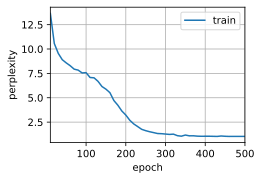

In [107]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

## 使用随机抽样的方法

困惑度 1.3, 165332.8 词元/秒 cuda:0
time travellerit s against reason said filbywhat we can mo is al
travellerit s against reason said filbywhat we can ropertar


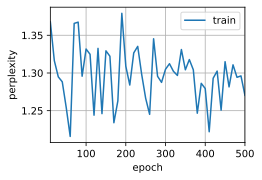

In [109]:
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(), use_random_iter=True)